In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
from IPython.display import Image, display
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.metrics import Recall, Precision
from keras.utils import plot_model
import tensorflow as tf

2025-11-18 08:21:32.419138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 08:21:32.423126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 08:21:32.433740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-18 08:21:32.449402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-18 08:21:32.453892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-18 08:21:32.466510: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    #plot_model(model, show_shapes=True, to_file='model_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(), Precision()])
    return model

In [3]:
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    #model.fit(X, inputy, epochs=10, batch_size=1000, verbose=1)
    model.fit(X, inputy, epochs=3, batch_size=256, verbose=1)

In [4]:
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.evaluate(X, verbose=1)

In [5]:
def evaluate_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    return model.evaluate(X, inputy, verbose=1)

In [6]:
def make_functional(model):
    # Create new Input
    inp = tf.keras.Input(shape=(39,))
    out = model(inp)               # call loaded model <-- REBUILDS symbolic graph
    func_model = tf.keras.Model(inp, out)
    return func_model

In [7]:
filename_model_N1 = '../Train/model_N1.keras'
loaded_model_N1 = load_model(filename_model_N1)

In [8]:
filename_model_N2 = '../Train/model_N2.keras'
loaded_model_N2 = load_model(filename_model_N2)

In [9]:
filename_model_N3 = '../Train/model_N3.keras'
loaded_model_N3 = load_model(filename_model_N3)

In [10]:
filename_model_N4 = '../Train/model_N4.keras'
loaded_model_N4 = load_model(filename_model_N4)

In [11]:
filename_model_N5 = '../Train/model_N5.keras'
loaded_model_N5 = load_model(filename_model_N5)

In [12]:
all_models_N1 = [
    make_functional(loaded_model_N2),
    make_functional(loaded_model_N3),
    make_functional(loaded_model_N4),
    make_functional(loaded_model_N5),
]

In [13]:
stacked_model_N1 = define_stacked_model(all_models_N1)

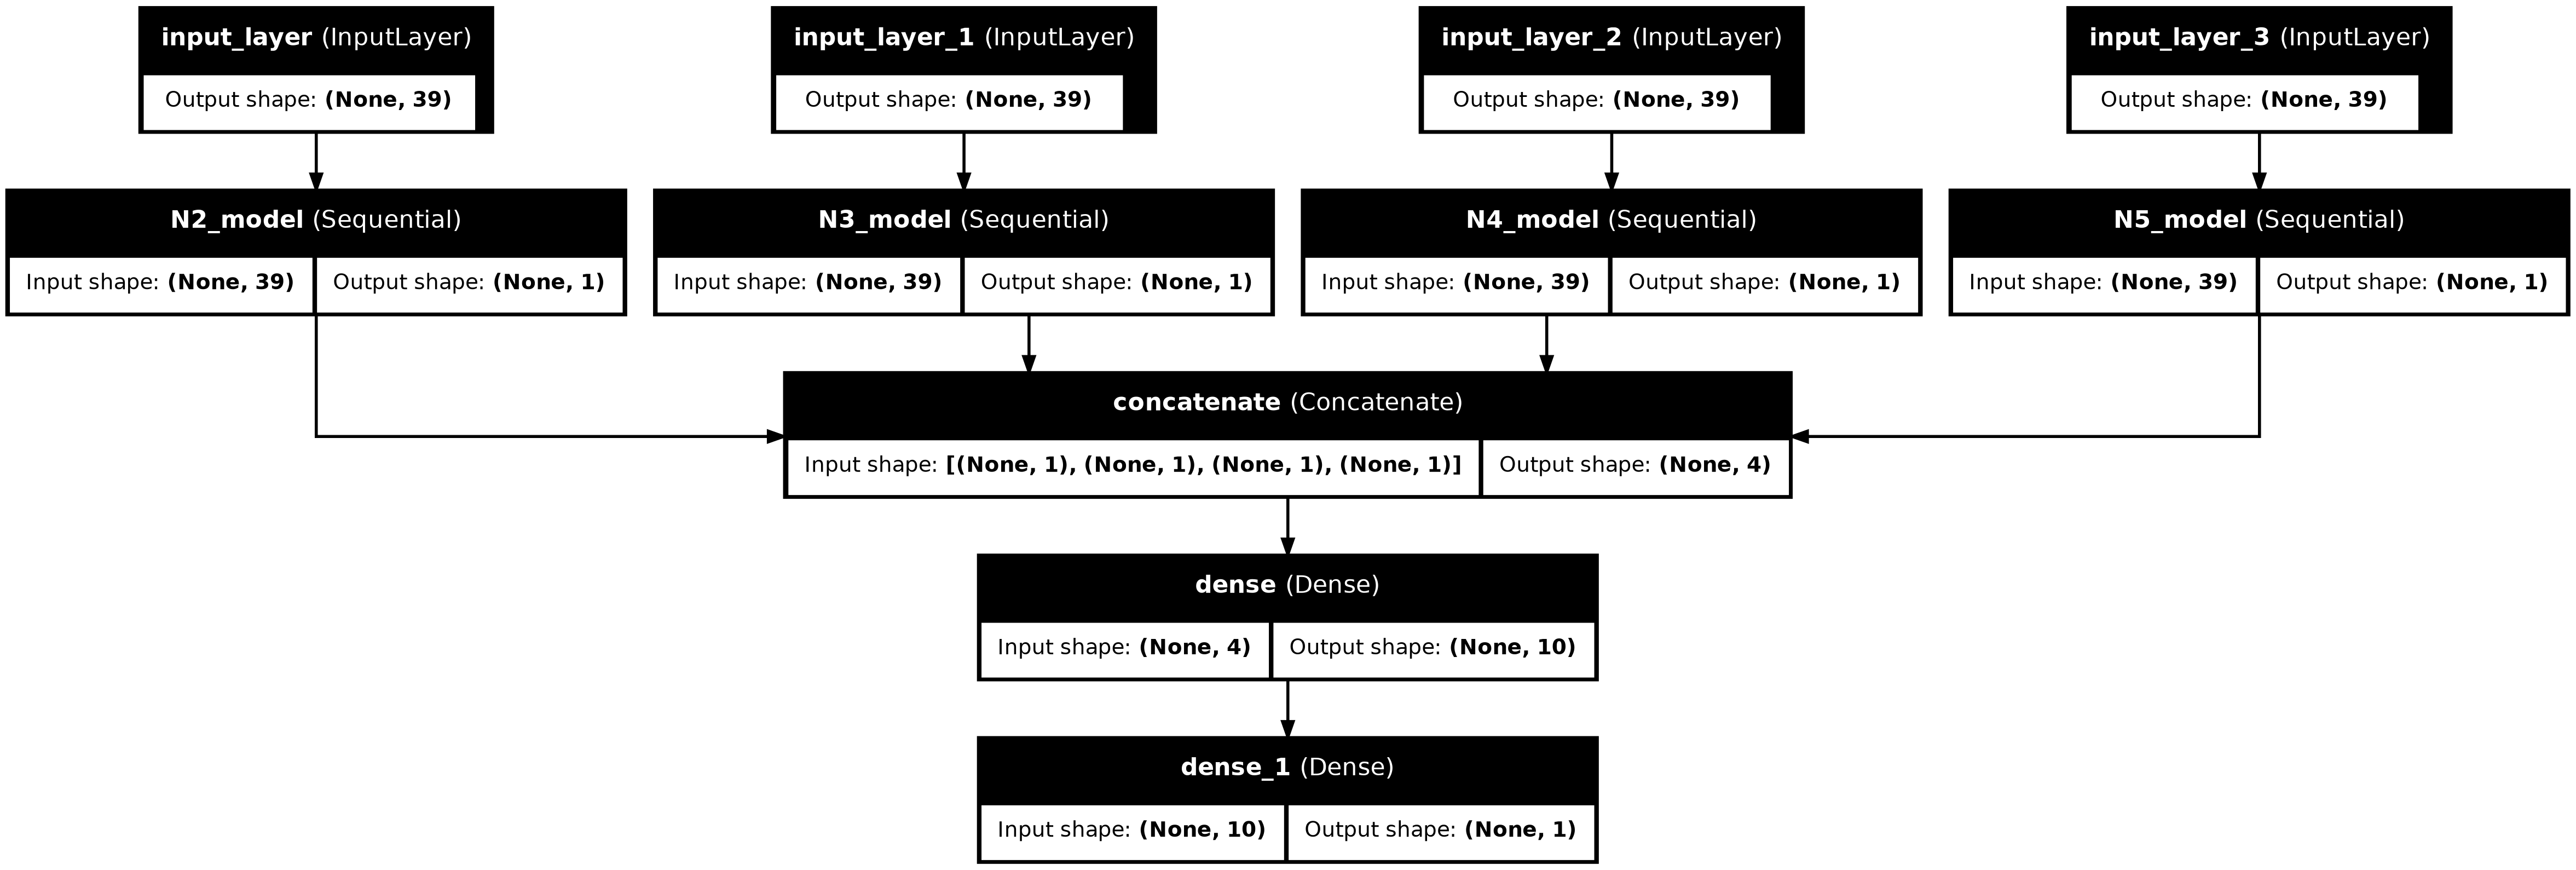

In [14]:
plot_model(
    stacked_model_N1,
    to_file="stacked_model_sec2_N1.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec2_N1.png"))

In [15]:
df1_test = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_test.parquet")

In [16]:
df1_sample = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_sample.parquet")

In [17]:
df1_valid = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_valid.parquet")

In [18]:
load_X_df1_sample = df1_sample.drop(["Label"],axis=1)
Y_df1_sample = df1_sample["Label"]

In [19]:
load_X_df1_test = df1_test.drop(["Label"],axis=1)
Y_df1_test = df1_test["Label"]

In [20]:
load_X_df1_valid = df1_valid.drop(["Label"],axis=1)
Y_df1_valid = df1_valid["Label"]

In [21]:
scaler_df1 = QuantileTransformer(output_distribution='normal')

In [22]:
X_df1_sample = scaler_df1.fit_transform(load_X_df1_sample)

In [23]:
X_df1_test = scaler_df1.fit_transform(load_X_df1_test)

In [24]:
X_df1_valid = scaler_df1.fit_transform(load_X_df1_valid)

In [25]:
fit_stacked_model(stacked_model_N1, X_df1_sample, Y_df1_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8570 - loss: 0.4802 - precision: 0.0536 - recall: 0.1768
Epoch 2/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9620 - loss: 0.1439 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9618 - loss: 0.1265 - precision: 0.0000e+00 - recall: 0.0000e+00


In [26]:
score_stack_N1 = evaluate_stacked_model(stacked_model_N1, X_df1_test, Y_df1_test)

print('Test loss:', score_stack_N1[0]) 
print('Test accuracy:', score_stack_N1[1])
print('Test recfor:', score_stack_N1[2]) 
print('Test precision:', score_stack_N1[3])

16764/16764 ━━━━━━━━━━━━━━━━━━━━ 16s 926us/step - accuracy: 0.9624 - loss: 0.1393 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 0.139547660946846
Test accuracy: 0.9623541831970215
Test recfor: 0.0
Test precision: 0.0


In [27]:
all_models_N2 = [
    make_functional(loaded_model_N1),
    make_functional(loaded_model_N3),
    make_functional(loaded_model_N4),
    make_functional(loaded_model_N5),
]

In [28]:
stacked_model_N2 = define_stacked_model(all_models_N2)

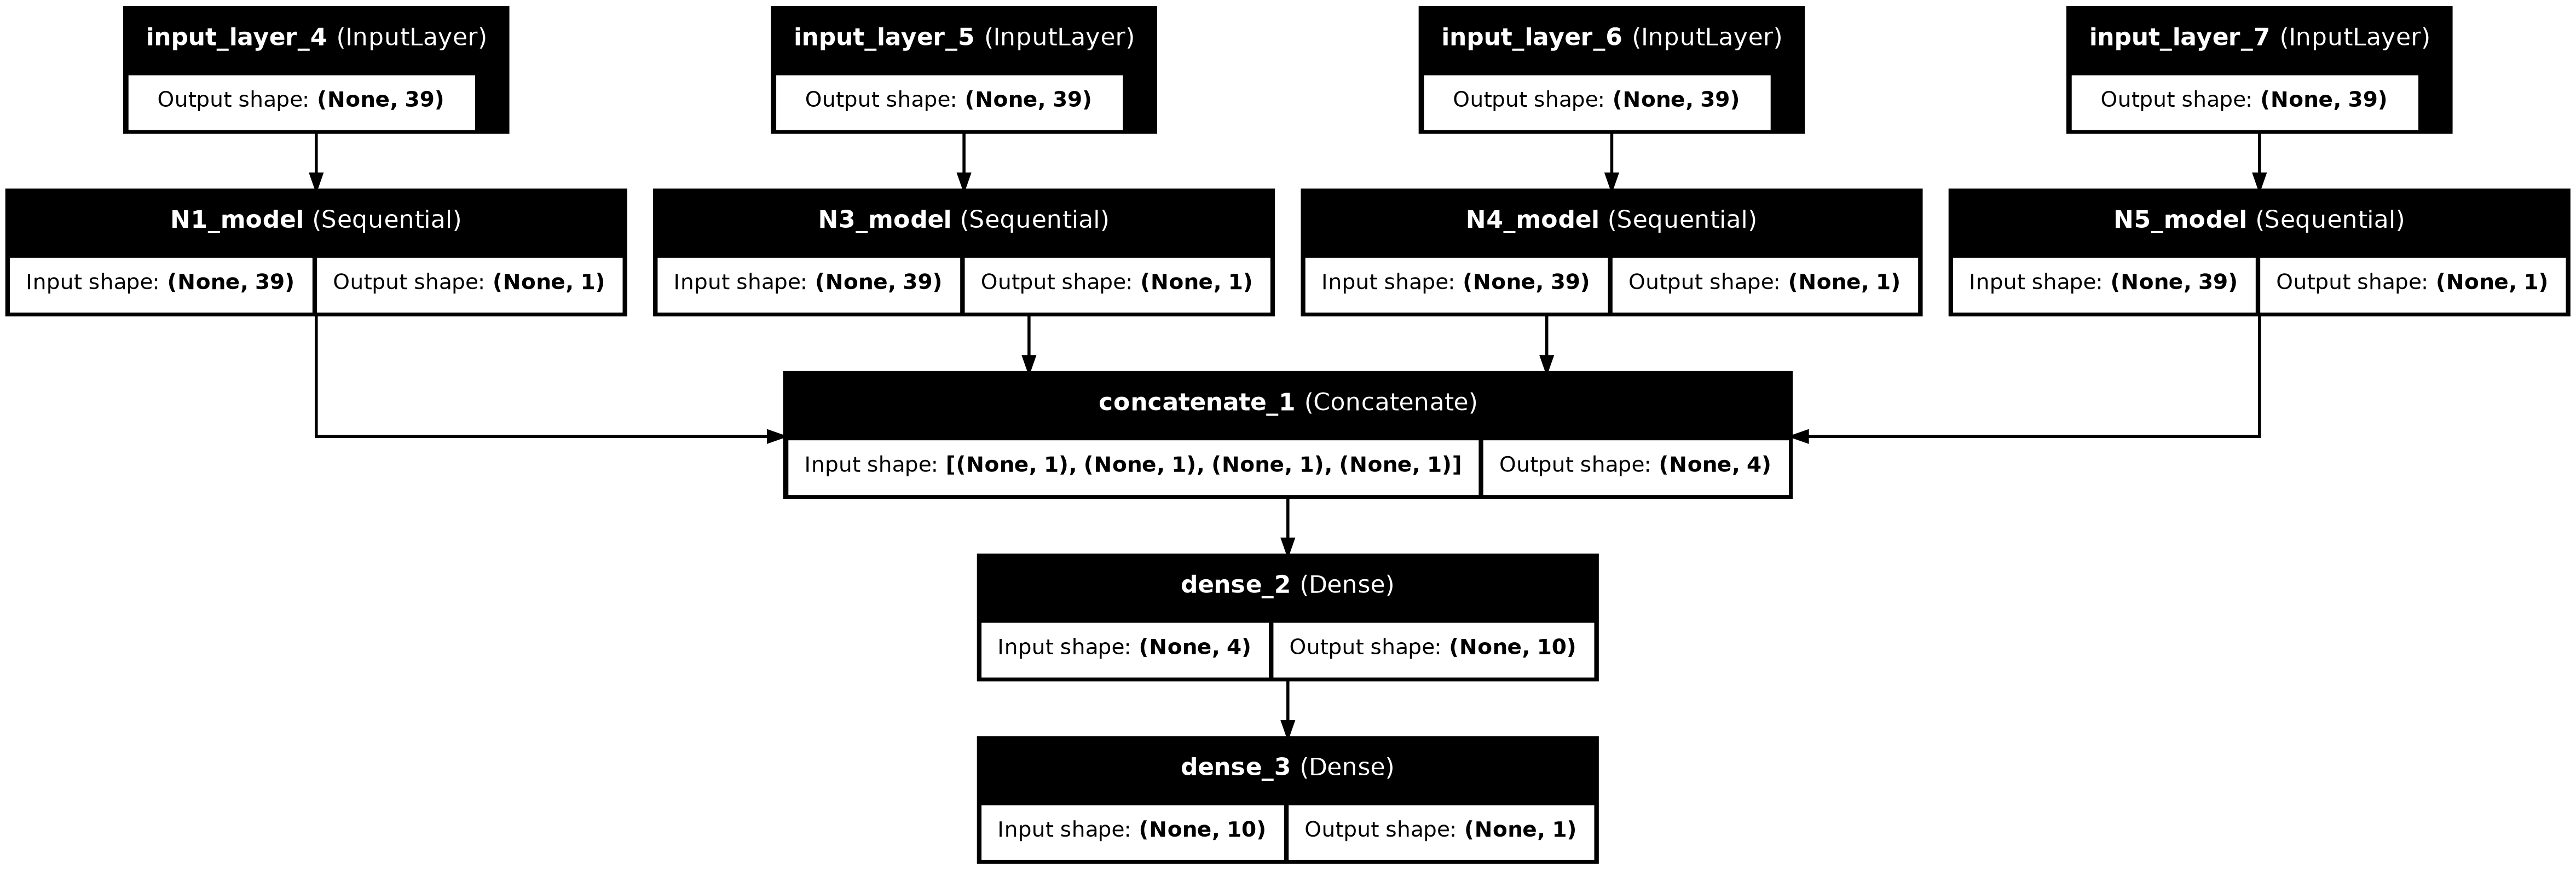

In [29]:
plot_model(
    stacked_model_N2,
    to_file="stacked_model_sec2_N2.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec2_N2.png"))

In [30]:
df2_test = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_test.parquet")

In [31]:
df2_sample = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_sample.parquet")

In [32]:
df2_valid = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_valid.parquet")

In [33]:
load_X_df2_sample = df2_sample.drop(["Label"],axis=1)
Y_df2_sample = df2_sample["Label"]

In [34]:
load_X_df2_test = df2_test.drop(["Label"],axis=1)
Y_df2_test = df2_test["Label"]

In [35]:
load_X_df2_valid = df2_valid.drop(["Label"],axis=1)
Y_df2_valid = df2_valid["Label"]

In [36]:
scaler_df2 = QuantileTransformer(output_distribution='normal')

In [37]:
X_df2_sample = scaler_df2.fit_transform(load_X_df2_sample)

In [38]:
X_df2_test = scaler_df2.fit_transform(load_X_df2_test)

In [39]:
X_df2_valid = scaler_df2.fit_transform(load_X_df2_valid)

In [40]:
stacked_model_N2 = define_stacked_model(all_models_N2)

In [41]:
fit_stacked_model(stacked_model_N2, X_df2_sample, Y_df2_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_86', 'keras_tensor_88', 'keras_tensor_90', 'keras_tensor_92']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6875 - loss: 0.5817 - precision_2: 0.7257 - recall_2: 0.9120
Epoch 2/3
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8350 - loss: 0.4330 - precision_2: 0.8196 - recall_2: 0.9928
Epoch 3/3
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8949 - loss: 0.3681 - precision_2: 0.8859 - recall_2: 0.9814


In [42]:
score_stack_N2 = evaluate_stacked_model(stacked_model_N2, X_df2_test, Y_df2_test)

print('Test loss:', score_stack_N2[0]) 
print('Test accuracy:', score_stack_N2[1])
print('Test recfor:', score_stack_N2[2]) 
print('Test precision:', score_stack_N2[3])

110834/110834 ━━━━━━━━━━━━━━━━━━━━ 102s 919us/step - accuracy: 0.8912 - loss: 0.3492 - precision_2: 0.8850 - recall_2: 0.9772
Test loss: 0.3497251868247986
Test accuracy: 0.8908979296684265
Test recfor: 0.9771659970283508
Test precision: 0.8846144080162048


In [43]:
all_models_N3 = [
    make_functional(loaded_model_N1),
    make_functional(loaded_model_N2),
    make_functional(loaded_model_N4),
    make_functional(loaded_model_N5),
]

In [44]:
stacked_model_N3 = define_stacked_model(all_models_N3)

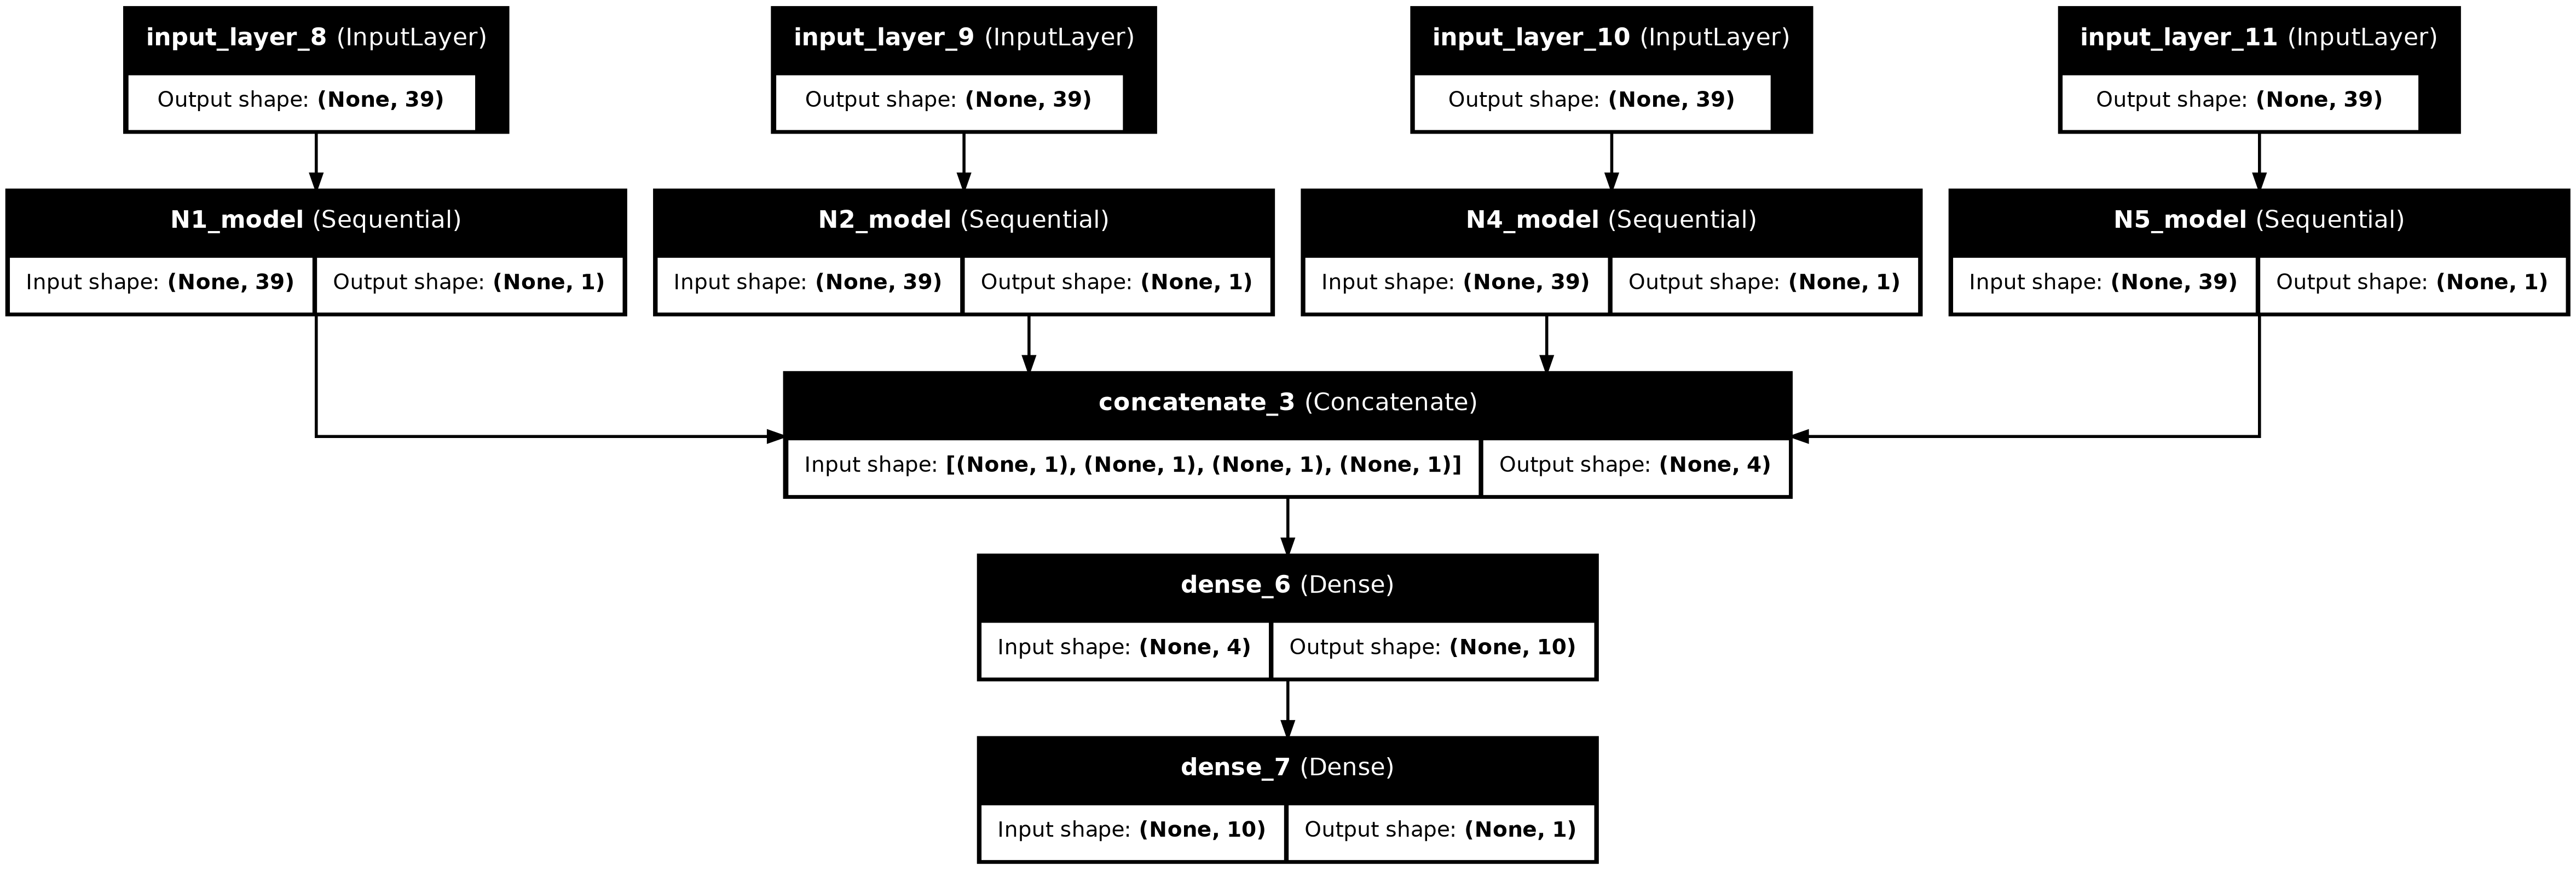

In [45]:
plot_model(
    stacked_model_N3,
    to_file="stacked_model_sec2_N3.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec2_N3.png"))

In [46]:
df3_test = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_test.parquet")

In [47]:
df3_sample = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_sample.parquet")

In [48]:
df3_valid = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_valid.parquet")

In [49]:
load_X_df3_sample = df3_sample.drop(["Label"],axis=1)
Y_df3_sample = df3_sample["Label"]

In [50]:
load_X_df3_test = df3_test.drop(["Label"],axis=1)
Y_df3_test = df3_test["Label"]

In [51]:
load_X_df3_valid = df3_valid.drop(["Label"],axis=1)
Y_df3_valid = df3_valid["Label"]

In [52]:
scaler_df3 = QuantileTransformer(output_distribution='normal')

In [53]:
X_df3_sample = scaler_df3.fit_transform(load_X_df3_sample)

In [54]:
X_df3_test = scaler_df3.fit_transform(load_X_df3_test)

In [55]:
X_df3_valid = scaler_df3.fit_transform(load_X_df3_valid)

In [56]:
fit_stacked_model(stacked_model_N3, X_df3_sample, Y_df3_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_100', 'keras_tensor_102', 'keras_tensor_104', 'keras_tensor_106']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


8318/8318 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9886 - loss: 0.0639 - precision_3: 0.9957 - recall_3: 0.9928
Epoch 2/3
8318/8318 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9959 - loss: 0.0186 - precision_3: 0.9959 - recall_3: 1.0000
Epoch 3/3
8318/8318 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9958 - loss: 0.0184 - precision_3: 0.9958 - recall_3: 0.9999


In [57]:
score_stack_N3 = evaluate_stacked_model(stacked_model_N3, X_df3_test, Y_df3_test)

print('Test loss:', score_stack_N3[0]) 
print('Test accuracy:', score_stack_N3[1])
print('Test recfor:', score_stack_N3[2]) 
print('Test precision:', score_stack_N3[3])

256670/256670 ━━━━━━━━━━━━━━━━━━━━ 241s 937us/step - accuracy: 0.9959 - loss: 0.0202 - precision_3: 0.9960 - recall_3: 0.9999
Test loss: 0.02001611888408661
Test accuracy: 0.9959506392478943
Test recfor: 0.9999362826347351
Test precision: 0.9960127472877502


In [58]:
all_models_N4 = [
    make_functional(loaded_model_N1),
    make_functional(loaded_model_N2),
    make_functional(loaded_model_N3),
    make_functional(loaded_model_N5),
]

In [59]:
stacked_model_N4 = define_stacked_model(all_models_N4)

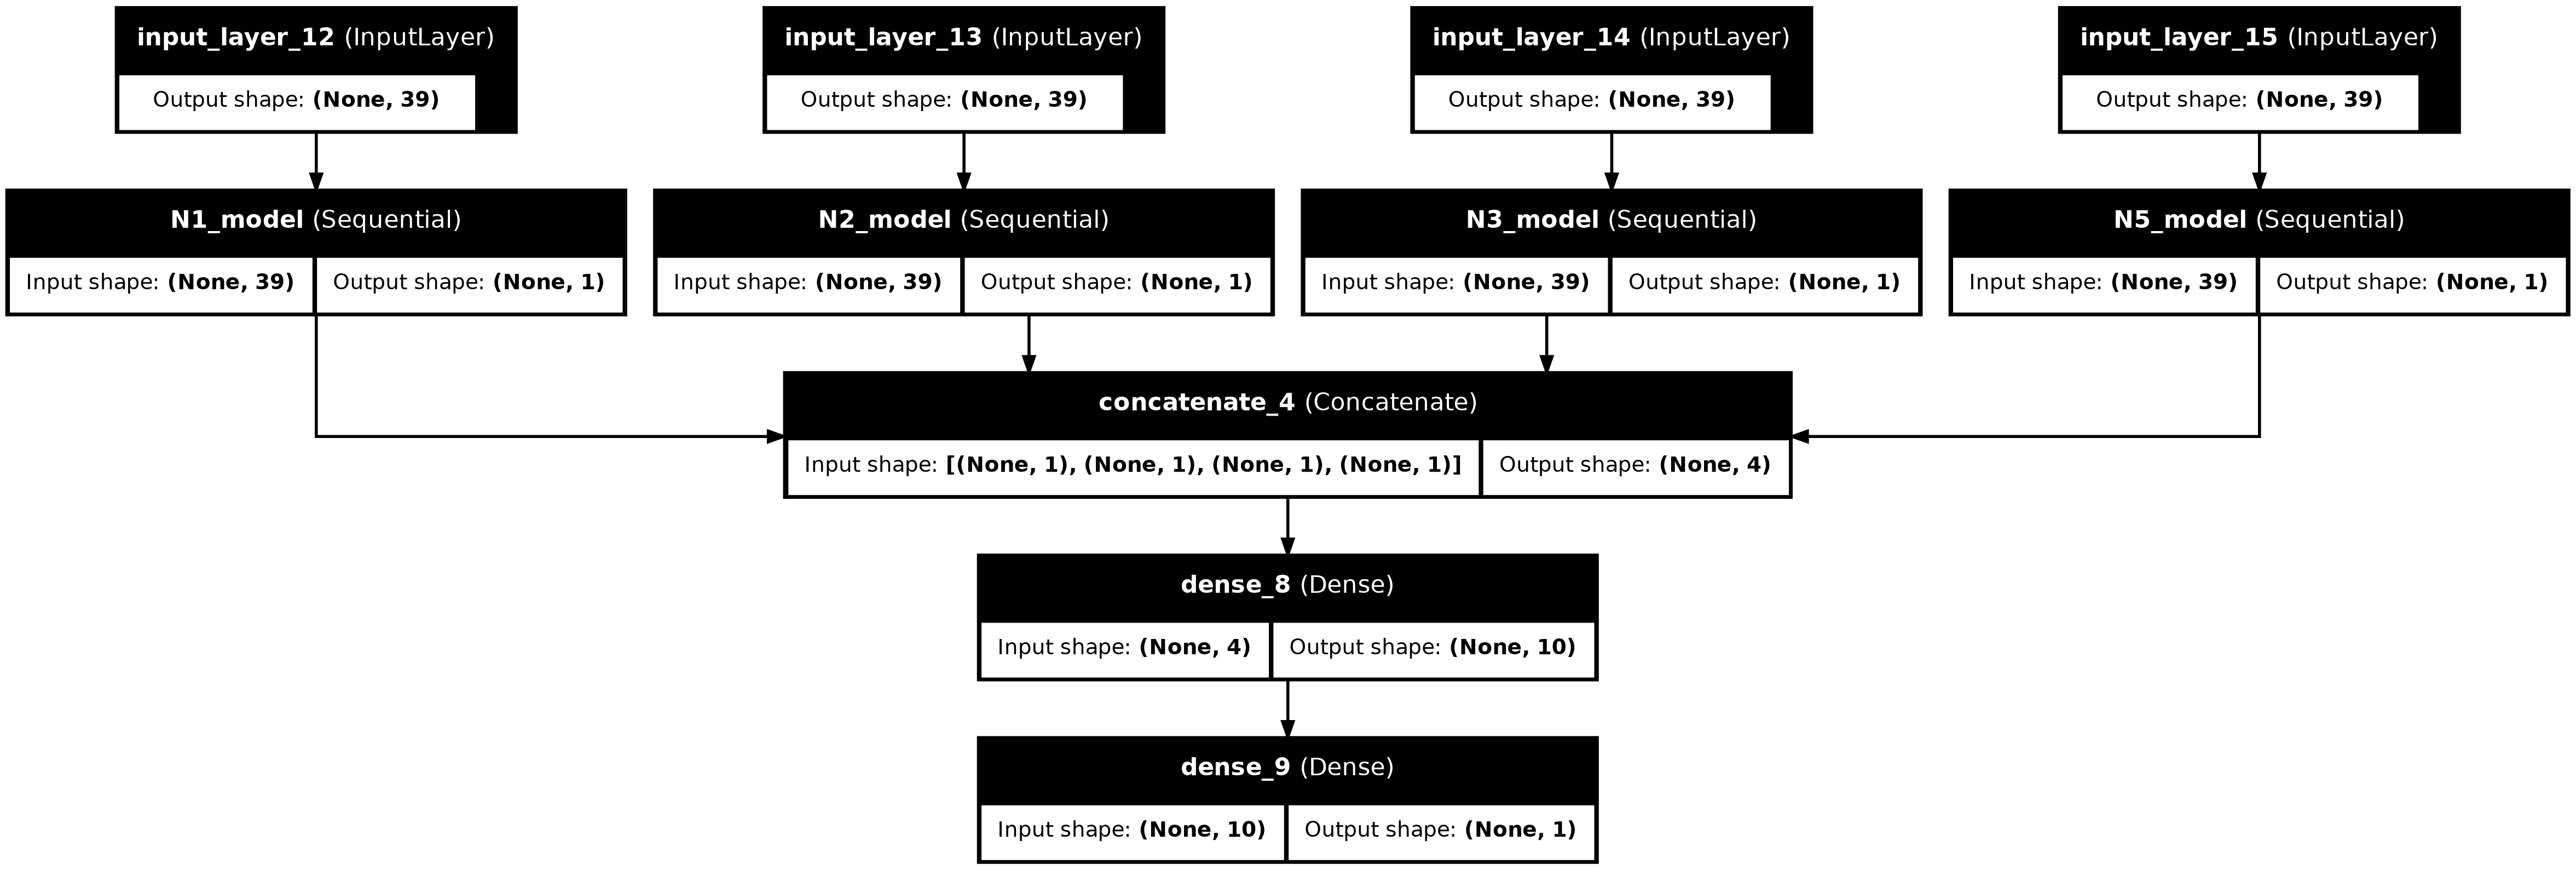

In [60]:
plot_model(
    stacked_model_N4,
    to_file="stacked_model_sec2_N4.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec2_N4.png"))

In [61]:
df4_test = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_test.parquet")

In [62]:
df4_sample = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_sample.parquet")

In [63]:
df4_valid = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_valid.parquet")

In [64]:
load_X_df4_sample = df4_sample.drop(["Label"],axis=1)
Y_df4_sample = df4_sample["Label"]

In [65]:
load_X_df4_test = df4_test.drop(["Label"],axis=1)
Y_df4_test = df4_test["Label"]

In [66]:
load_X_df4_valid = df4_valid.drop(["Label"],axis=1)
Y_df4_valid = df4_valid["Label"]

In [67]:
scaler_df4 = QuantileTransformer(output_distribution='normal')

In [68]:
X_df4_sample = scaler_df4.fit_transform(load_X_df4_sample)

In [69]:
X_df4_test = scaler_df4.fit_transform(load_X_df4_test)

In [70]:
X_df4_valid = scaler_df4.fit_transform(load_X_df4_valid)

In [71]:
fit_stacked_model(stacked_model_N4, X_df4_sample, Y_df4_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_111', 'keras_tensor_113', 'keras_tensor_115', 'keras_tensor_117']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


4684/4684 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9154 - loss: 0.2843 - precision_4: 0.7299 - recall_4: 0.4485
Epoch 2/3
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9448 - loss: 0.1591 - precision_4: 0.8913 - recall_4: 0.6078
Epoch 3/3
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9535 - loss: 0.1524 - precision_4: 0.9126 - recall_4: 0.6721


In [72]:
score_stack_N4 = evaluate_stacked_model(stacked_model_N4, X_df4_test, Y_df4_test)

print('Test loss:', score_stack_N4[0]) 
print('Test accuracy:', score_stack_N4[1])
print('Test recfor:', score_stack_N4[2]) 
print('Test precision:', score_stack_N4[3])

144532/144532 ━━━━━━━━━━━━━━━━━━━━ 139s 956us/step - accuracy: 0.8895 - loss: 0.2334 - precision_4: 0.7649 - recall_4: 0.0975
Test loss: 0.23325322568416595
Test accuracy: 0.889532208442688
Test recfor: 0.0971713438630104
Test precision: 0.763114869594574


In [73]:
all_models_N5 = [
    make_functional(loaded_model_N1),
    make_functional(loaded_model_N2),
    make_functional(loaded_model_N3),
    make_functional(loaded_model_N4),
]

In [74]:
stacked_model_N5 = define_stacked_model(all_models_N5)

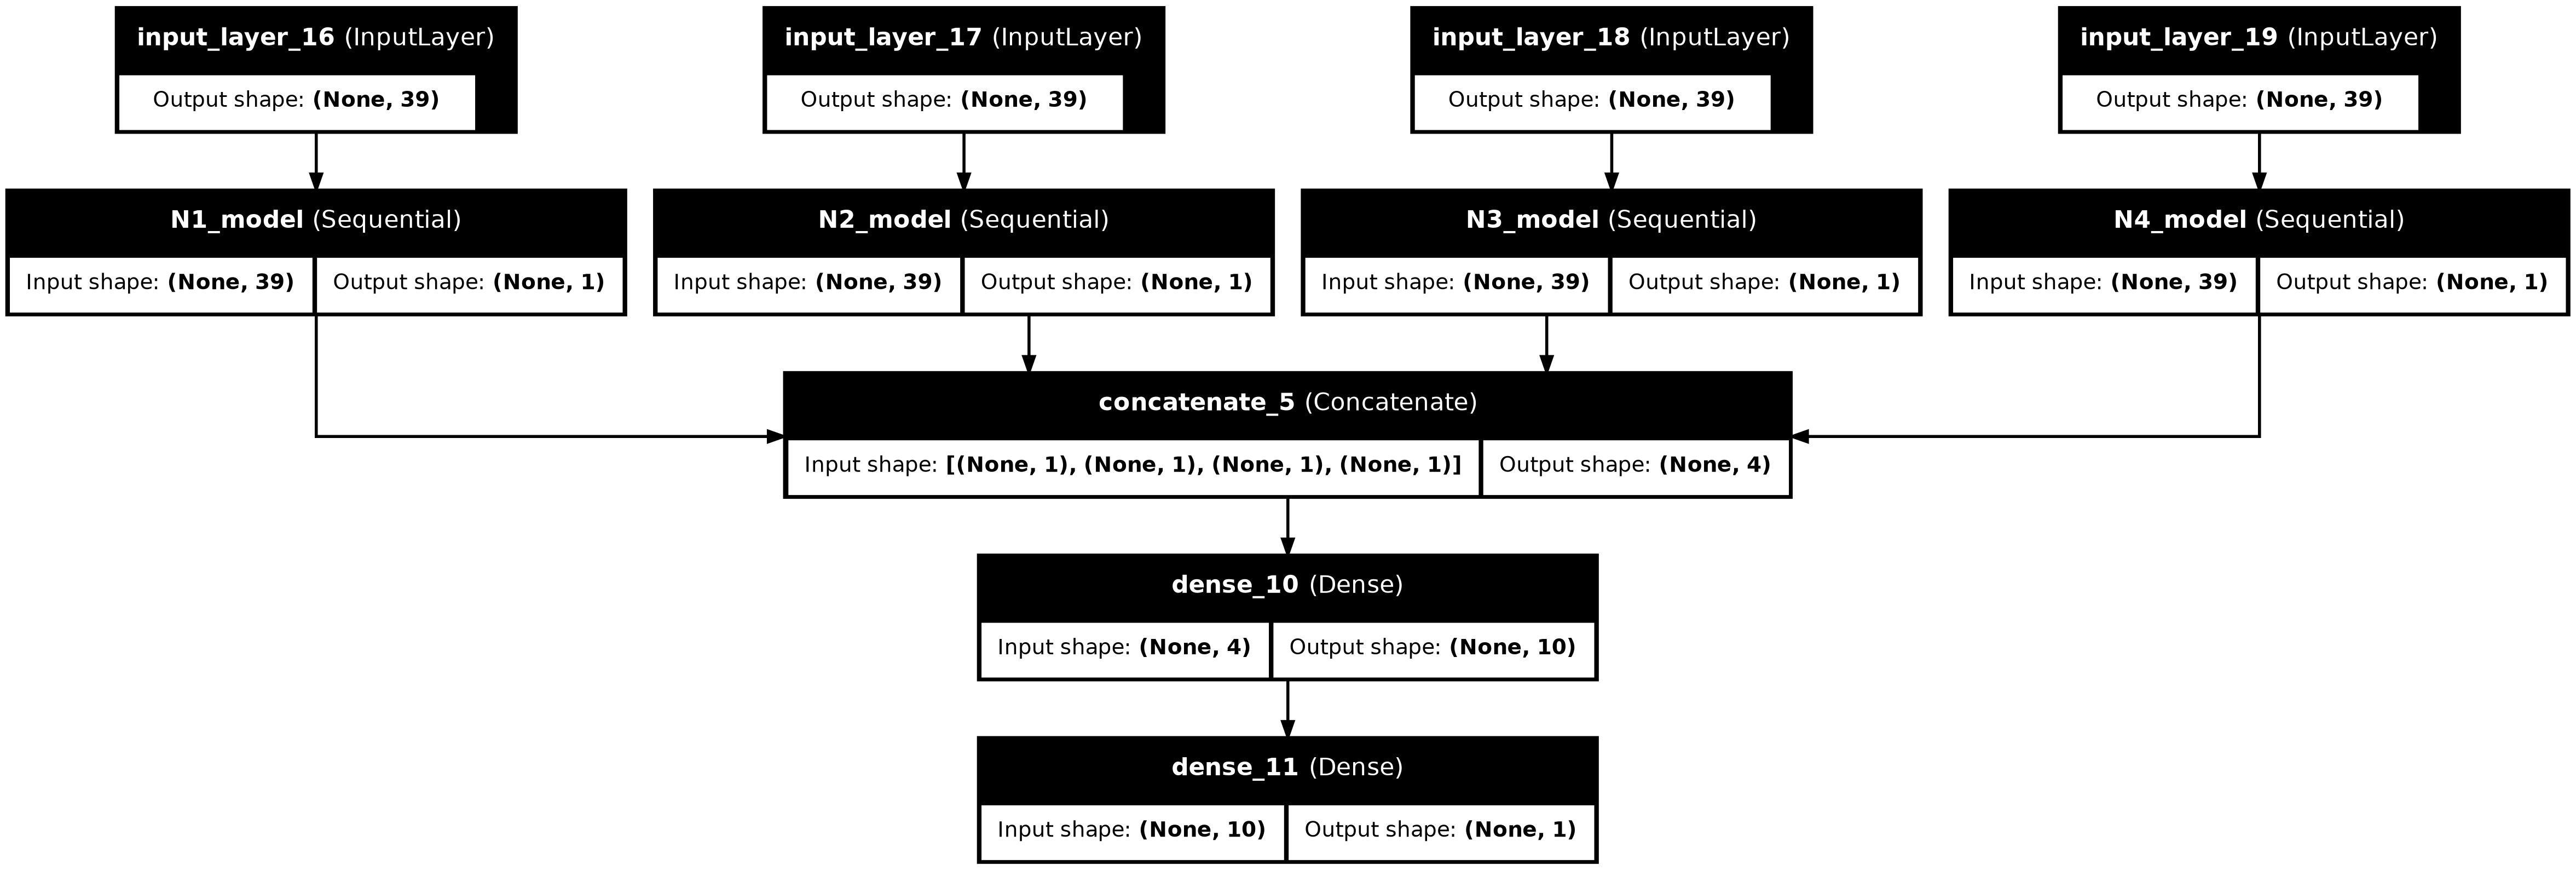

In [75]:
plot_model(
    stacked_model_N5,
    to_file="stacked_model_sec2_N5.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec2_N5.png"))

In [76]:
df5_test = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_test.parquet")

In [77]:
df5_sample = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_sample.parquet")

In [78]:
df5_valid = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_valid.parquet")

In [79]:
load_X_df5_sample = df5_sample.drop(["Label"],axis=1)
Y_df5_sample = df5_sample["Label"]

In [80]:
load_X_df5_test = df5_test.drop(["Label"],axis=1)
Y_df5_test = df5_test["Label"]

In [81]:
load_X_df5_valid = df5_valid.drop(["Label"],axis=1)
Y_df5_valid = df5_valid["Label"]

In [82]:
scaler_df5 = QuantileTransformer(output_distribution='normal')

In [83]:
X_df5_sample = scaler_df5.fit_transform(load_X_df5_sample)

In [84]:
X_df5_test = scaler_df5.fit_transform(load_X_df5_test)

In [85]:
X_df5_valid = scaler_df5.fit_transform(load_X_df5_valid)

In [86]:
fit_stacked_model(stacked_model_N5, X_df5_sample, Y_df5_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_122', 'keras_tensor_124', 'keras_tensor_126', 'keras_tensor_128']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


17137/17137 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8535 - loss: 0.3514 - precision_5: 0.8600 - recall_5: 0.9364
Epoch 2/3
17137/17137 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.8776 - loss: 0.2896 - precision_5: 0.8975 - recall_5: 0.9224
Epoch 3/3
17137/17137 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.8820 - loss: 0.2836 - precision_5: 0.8990 - recall_5: 0.9279


In [87]:
score_stack_N5 = evaluate_stacked_model(stacked_model_N5, X_df5_test, Y_df5_test)

print('Test loss:', score_stack_N5[0]) 
print('Test accuracy:', score_stack_N5[1])
print('Test recfor:', score_stack_N5[2]) 
print('Test precision:', score_stack_N5[3])

528796/528796 ━━━━━━━━━━━━━━━━━━━━ 496s 936us/step - accuracy: 0.8652 - loss: 0.3512 - precision_5: 0.8956 - recall_5: 0.9039
Test loss: 0.3512972891330719
Test accuracy: 0.8651795387268066
Test recfor: 0.9037322402000427
Test precision: 0.8957169055938721
